## Step 01 - Creating a Spark Context and Spark session

In the cell below, a spark context has been created by assigning all the cores available for spark computations.
The spark sessions has been created with optional configurations i.e. importing the spark connector in the virtual environment, defining a default mongo DB database and the collection for writting and readign data.

In [48]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
from pyspark import SparkContext 
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()

if (sc is None):
    sc = SparkContext(master="local[*]")
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("MongoDB and Apache Spark")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.Assignment1B_collection")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.Assignment1B_collection")\
        .getOrCreate()

## Step - 02 Creating a Dataframe

Reading a CSV file into spark and creating a dataframe.

Also counting the number of records in the CSV file

In [49]:
Crime_stat_SA_DataFrame = spark.read.csv('Crime_Statistics_SA_2010_present.csv', header=True, inferSchema=True)
Crime_stat_SA_DataFrame.na.drop()
Number_of_records = Crime_stat_SA_DataFrame.count()
print("Number of Records in Data Frame:", Number_of_records)

Number of Records in Data Frame: 727408


## Step 03 - Write to Database

Pushing the dataframe made in  the previous step to MongoDb to maintain a remote copy of the dataset

In [50]:
Crime_stat_SA_DataFrame.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

## Step 04 - Read from Database

Reading the data pushed in the previous step from MongoDB into spark and making a new dataframe

In [6]:
Crime_stat_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

## Calculating the statistics of numeric and String column

The statistics of "Reported Date" and "Offence Count" in the dataframe using the describe function.

#### Explanation for minimum and maximum Reported Date
The Miminum and Maximum and of the Reported Date Column is not Correct and the minimum and maximum is based on the integer value of date not the actual date. The minimum date in the data set is in the year 2010 and the maximum date in the data set is in year 2019.

In [7]:
coulmn_select = ['Reported Date','Offence Count']
Statistics_df = Crime_stat_df.select(*coulmn_select).describe()
Statistics_df.show()

+-------+-------------+------------------+
|summary|Reported Date|     Offence Count|
+-------+-------------+------------------+
|  count|       727407|            727407|
|   mean|         null|1.1715174585892079|
| stddev|         null|0.5787050930378091|
|    min|    1/01/2011|                 1|
|    max|    9/12/2018|                28|
+-------+-------------+------------------+



## Step 06 - Change the data type of a column

Changed the type of "Reported Date" from string type to Date type and overwrite the Reported Date column. Used the with column to overwrite the column and used t_date SQL function to change the "Reported Date" from being String to Date Type

In [8]:
from pyspark.sql.types import DateType
from pyspark.sql.functions import col
from pyspark.sql.functions import to_date
from pyspark.sql.functions import udf
from datetime import datetime

DateModified_df = Crime_stat_df.withColumn('Reported Date',to_date(Crime_stat_df['Reported Date'], 'dd/MM/yyyy'))
DateModified_df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 08 - Preliminary data analysis

### Step - 08 part 1 - Number of level 2 offences

Displaying the count and list of Level 2 offences by using the groupBy and filter the level 2 type offences from the main dataframe.

In [9]:
Level_2_offence_df = DateModified_df.groupBy('Offence Level 2 Description').count()
Level_2_offence_df = Level_2_offence_df.filter(Level_2_offence_df['Offence Level 2 Description'].isNotNull())
print("Number of Level 2 offences:",Level_2_offence_df.count())
Level_2_offence_df.show(Level_2_offence_df.count(),False)

Number of Level 2 offences: 9
+------------------------------------+------+
|Offence Level 2 Description         |count |
+------------------------------------+------+
|ROBBERY AND RELATED OFFENCES        |5848  |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |166161|
|SEXUAL ASSAULT AND RELATED OFFENCES |13403 |
|HOMICIDE AND RELATED OFFENCES       |443   |
|ACTS INTENDED TO CAUSE INJURY       |112961|
|SERIOUS CRIMINAL TRESPASS           |104952|
|OTHER OFFENCES AGAINST THE PERSON   |23407 |
|FRAUD DECEPTION AND RELATED OFFENCES|19661 |
|THEFT AND RELATED OFFENCES          |280571|
+------------------------------------+------+



### Step - 08 part 2 - Number of offences against the person

Displaying the number of offences against the person. using the filter function to pull out all the offences against the person and used th ecount function to count the number of offences.

In [10]:
Offence_against_person_df = DateModified_df.filter(DateModified_df['Offence Level 1 Description'] == "OFFENCES AGAINST THE PERSON").count()
print("Number of Offences Against The Person:", Offence_against_person_df)

Number of Offences Against The Person: 156062


### Step - 08 part 3 - Serious criminal tresspasses with more than 1 offence count

Displaying the number of records categorized as serious criminal tresspasses and used the filter function to pull out the specific records with number of offences grater than 1

In [11]:
serious_cr_tres_df = DateModified_df.filter(DateModified_df['Offence Level 2 Description'] == "SERIOUS CRIMINAL TRESPASS")
print("Number of Serial criminal trespass with more than 1 Offence Count:", serious_cr_tres_df.filter(serious_cr_tres_df['Offence Count'] > 1).count())

Number of Serial criminal trespass with more than 1 Offence Count: 8579


### Step - 08 part 4 - Percentage of crimes that are offences against the property

Calculating the percentage of crimes that are serious criminal tresspasses. For the same, used the filter function to get all the records registered as offences against the property. Used the groupBy and sum function to find the total number of offences. Divided the Offences obtained by grouping in previous step by the total number of offences to get the percentage of crimes that a offences against the property.

In [12]:
Offence_againt_property = DateModified_df.filter(DateModified_df['Offence Level 1 Description'] == "OFFENCES AGAINST PROPERTY")
Offence_againt_property_count = Offence_againt_property.groupby().sum().collect()[0][0]
total_offence_count = DateModified_df.groupby().sum().collect()[0][0]
percentage_crime_agaimst_property = (Offence_againt_property_count/total_offence_count)*100
print("Percentage crime against property:",round(percentage_crime_agaimst_property, 3),'%')

Percentage crime against property: 79.389 %


## Step 08 - Exploratory data analysis

Importing SQL function month, year, dayofmonth to split the Reported date to date, month and year for exploratory analysis.

Splitting the Reported date column into day, month and year and storing them in mew column in the datafame by using withColumn function.

In [13]:
from pyspark.sql.functions import month
from pyspark.sql.functions import dayofmonth
from pyspark.sql.functions import year 

ymd_df = DateModified_df.withColumn('Reported Year', year(col('Reported Date')))\
.withColumn('Reported Month', month(col('Reported Date')))\
.withColumn('Reported Day', dayofmonth(col('Reported Date')))

Importing matplotlib and numpy to plot the results of the exploratory analysis.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid')
%matplotlib inline

### Step 08 - part 1 - Crimes per year

Used the groupBy and sum function on the dataframe to group the offences by the year that they reported in and to count the number of offences per year.

The number of Offences per year sre added to a list to pass it to the function to plot a bar graph.

In [15]:
ymd_df = ymd_df.filter(ymd_df['Reported Date'].isNotNull())
crimeByYear_df = ymd_df.groupBy('Reported Year').sum('Offence Count')
crimeByYear = crimeByYear_df.sort('Reported Year').collect()

Plotting a bar graph of offence count on Y axis and the year on X axis.

#### Explanation of the graph
The graph plotted shows that the crime count has reduced over the years from 2010 to 2019. The most number offences took place in year 2011.

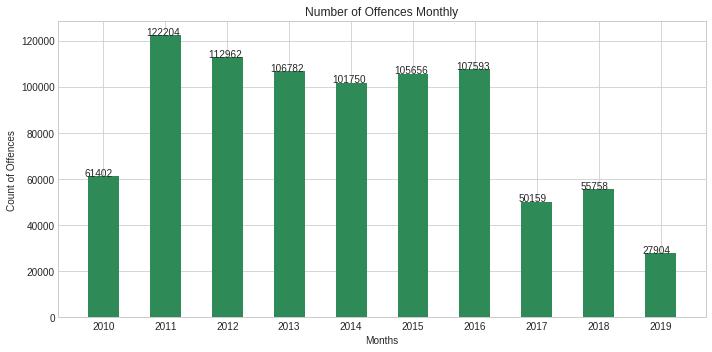

In [52]:
y_axis = [row['sum(Offence Count)'] for row in crimeByYear]
bar_width = 0.5
years = ('2010', '2011', '2012','2013','2014','2015','2016','2017','2018','2019')
y_pos = np.arange(len(years))
plt.figure(figsize = (10,5))
plt.bar(y_pos, y_axis, bar_width, align='center', color='seagreen')
plt.xticks(y_pos, years)
plt.xlabel('Months')
plt.ylabel('Count of Offences')
plt.title('Number of Offences Monthly')
plt.tight_layout()
for i, v in enumerate(y_axis):
    plt.text(y_pos[i] - 0.3, v + 1, str(v))
plt.show()

### Step 08 - part 2 - Crimes per Month

The Offences count reported per month over different years were grouped together using the groupBy Function. the sun Function was used to count the number of offence each month.

In [53]:
ymd_df = ymd_df.filter(ymd_df['Reported Date'].isNotNull())
crimeByMonth_df = ymd_df.groupBy('Reported Month').sum('Offence Count')
crimeByMonth = crimeByMonth_df.sort('Reported Month').collect()

Plotting a bar graph of offence count on Y axis and the month on X axis.

#### Explanation of the graph
The graph plotted shows that the crime count is more than 600,000 for every month. In the month of Apr, March, June less crimes were reported compared to other months. The month of April has the least number of offences reportd over the years.

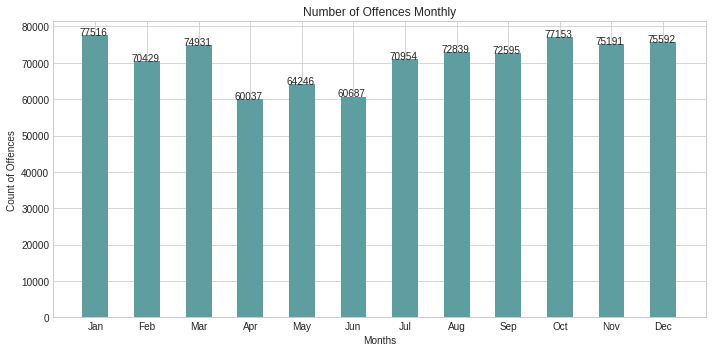

In [54]:
y_axis = [row['sum(Offence Count)'] for row in crimeByMonth]
bar_width = 0.5
months = ('Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
y_pos = np.arange(len(months))
plt.figure(figsize = (10,5))
plt.bar(y_pos, y_axis, bar_width, align='center', color='cadetblue')
plt.xticks(y_pos, months)
plt.xlabel('Months')
plt.ylabel('Count of Offences')
plt.title('Number of Offences Monthly')
plt.tight_layout()
for i, v in enumerate(y_axis):
    plt.text(y_pos[i] - 0.3, v + 0.1, str(v))
plt.show()

### Step 08 - part 3- Where to Most crimes take place (top 20)

Imported all SQL function to use the concat SQL function to concatenate the Suburb name and the corresponding pincode of the suburb and creating a new column with the concatenated . After concatinating, used the groupBy and sum function on the newly created column with the concatenated string to find the top 20 suburbs with highest crime count. To see the top 20 the result was sorted in descending order.

The list of top 20 suburb name and a list of the offence count was passed to the plot function to plot the result for visula representation.


In [55]:
from pyspark.sql import functions as sf

Loc_crime_df = DateModified_df.withColumn('Location-Pincode', sf.concat(sf.col('Suburb - Incident'),sf.lit('-'), sf.col('Postcode - Incident')))
LocationWise_crime_df = Loc_crime_df.groupBy('Location-Pincode').sum('Offence Count').sort('sum(Offence Count)', ascending=False)
LocationWise_crime = LocationWise_crime_df.take(20)

Plotting the Bar graph showing the top 20 suburbs with pincode and the offence Count for each suburb. for easy of understandng the number of offences is diplayed on top the bar for each suburb.

#### Explanation of the graph

Looking at the graph, clearly Adelaide-5000 is the suburb with most number of reported crimes. My understanding for the reason for such result is probably the poplation of Adelaide is higher than other suburbs and hence there chances of more crimes to take place over there.

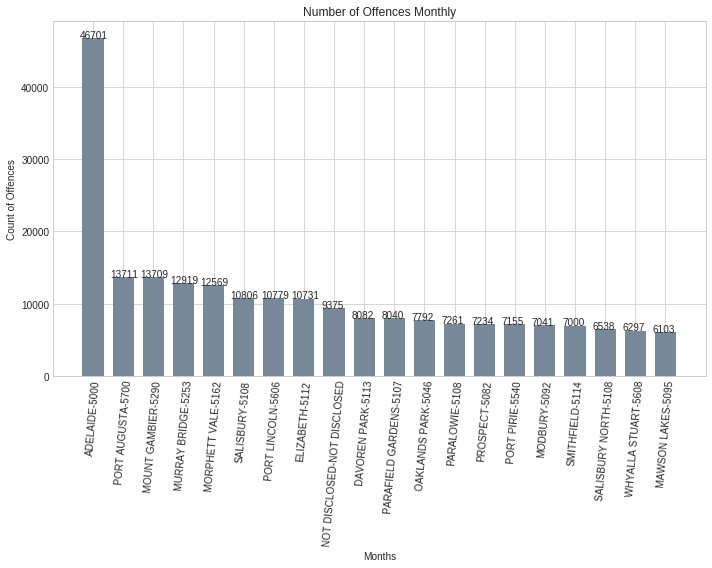

In [56]:
y_axis = [row['sum(Offence Count)'] for row in LocationWise_crime]
bar_width = 0.7
Locations = [row['Location-Pincode'] for row in LocationWise_crime]
y_pos = np.arange(len(Locations))
plt.figure(figsize = (10,8))
plt.bar(y_pos, y_axis, bar_width, align='center', color='lightslategrey')
plt.xticks(y_pos, Locations, rotation = 85)
plt.xlabel('Months')
plt.ylabel('Count of Offences')
plt.title('Number of Offences Monthly')
plt.tight_layout()
for i, v in enumerate(y_axis):
    plt.text(y_pos[i] - 0.43, v + 0.1, str(v))
plt.show()

### Step 08 - part 04 - Number of serious criminal tresspasses by day and month

In this part I have considered plotting two different types of graph to understan the data better.

First a new column fhas been ade in the dataframe with only the month and day of the reported crime using the withcolumn function.

Filtered the df with new column for serious criminal tress passes to fetch the data fro only that category.

Used the groupBy and sum function to find out the criminal offences that were serious criminal offences by day and month.

All this was done to plot a 2D line graph to see th trend in the data.

In [57]:
from pyspark.sql.functions import date_format
from pyspark.sql.functions import to_date

DateModified_df2 = DateModified_df.withColumn('Day/Month',date_format(DateModified_df['Reported Date'], 'MM-dd'))
Ser_crimnal_trespass = DateModified_df2.filter(DateModified_df['Offence Level 2 Description'] == "SERIOUS CRIMINAL TRESPASS")
crimeMMDD_df = Ser_crimnal_trespass.groupBy('Day/Month').sum('Offence Count')
crimeMMDD_df.na.drop()
Crime_mm_dd_df=crimeMMDD_df.filter(crimeMMDD_df['Day/Month'].isNotNull()).sort('Day/Month').collect()
date_list = [row['Day/Month'] for row in Crime_mm_dd_df]
offence_list = [row['sum(Offence Count)'] for row in Crime_mm_dd_df]
date_index = [1,31,60,91,121,152,182,213,244,274,305,335,366]
dates = ['1st Jan','31st Jan','29th Feb','31st Mar','30th Apr','31st May','30th Jun','31st Jul','31st Aug','30th Sep','31st Oct','30th Nov','31 Dec']

In the cell below the dataframe was manipulated in a different way to plot a scatter plot for offence count with respect to day and month. 

In the cell below a new df was formmed with Offence count, Reported month, Reported year and Offence Level 2 description columns. Filtered the new dataframe to get all the serious criminal offences. the used GroupBy, sum and sort to group by month and day, get the total offences count for each day of every month and then sorted by minth and day to get a serially ordered dataset for plotting.

In [58]:
df = ymd_df.select('Offence Count', 'Reported Month', 'Reported Day', 'Offence Level 2 Description')
df_temp = df.filter(df['Offence Level 2 Description'] == "SERIOUS CRIMINAL TRESPASS")
df_temp2 = df_temp.groupBy('Reported Day', 'Reported Month').sum('Offence Count').sort('Reported Month', 'Reported Day')
list_sr_cr2 = df_temp2.collect()
list_sr_cr =df_temp.collect()

Perparing the data for ploting by classifying data in different lists based on month and day

In [59]:
Offence_1 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 1]
Days_1 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 1]

Offence_2 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 2]
Days_2 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 2]

Offence_3 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 3]
Days_3 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 3]

Offence_4 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 4]
Days_4 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 4]

Offence_5 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 5]
Days_5 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 5]

Offence_6 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 6]
Days_6 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 6]

Offence_7 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 7]
Days_7 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 7]

Offence_8 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 8]
Days_8 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 8]

Offence_9 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 9]
Days_9 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 9]

Offence_10 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 10]
Days_10 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 10]

Offence_11 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 11]
Days_11 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 11]

Offence_12 = [row['sum(Offence Count)'] for row in list_sr_cr2 if row['Reported Month'] == 12]
Days_12 = [row['Reported Day'] for row in list_sr_cr2 if row['Reported Month'] == 12]

The cell below acepts all the lists made in the previous step to plot a scatter plot of offence count with respect to day and month. different colours weres user to denote different months.

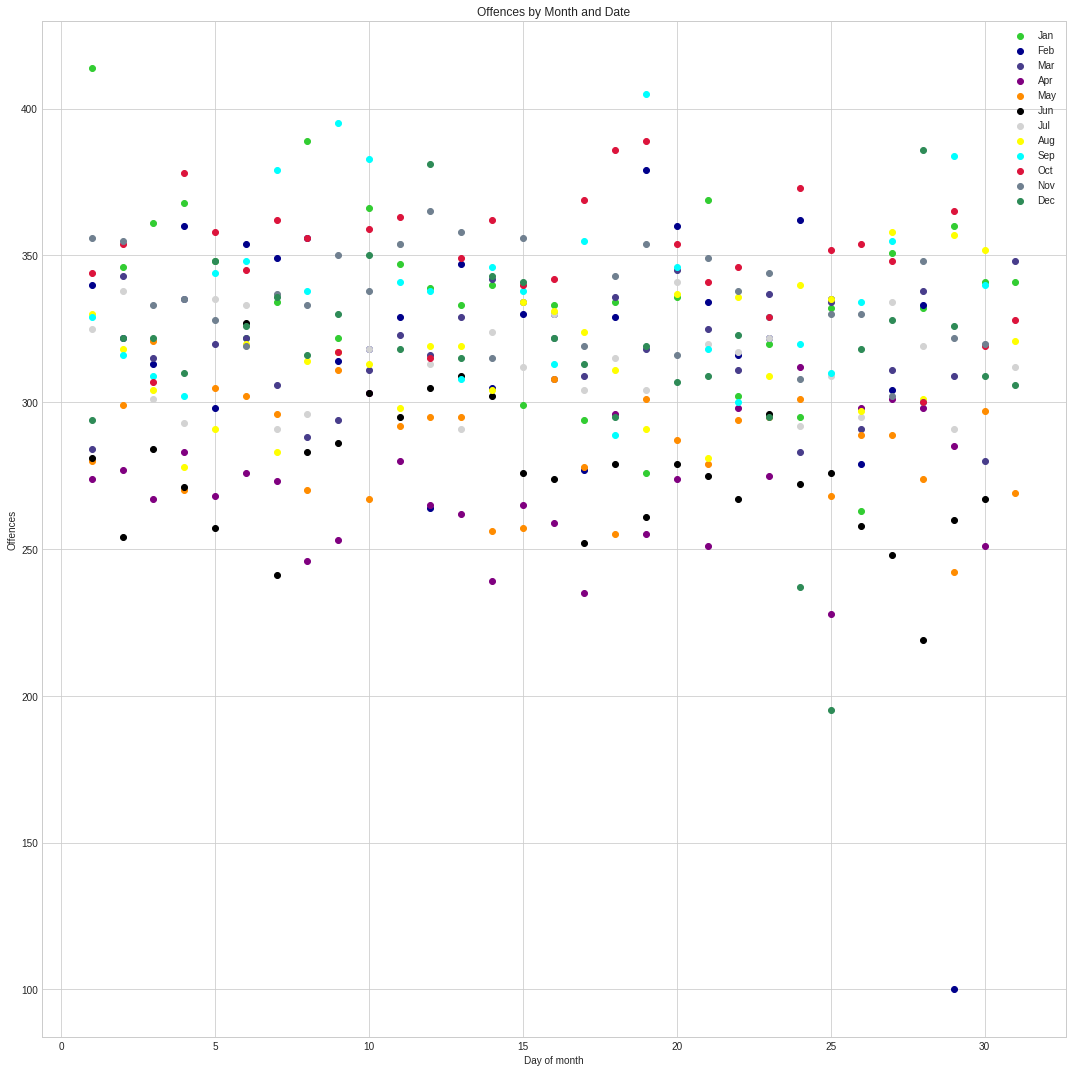

In [60]:
plt.figure(figsize = (15,15))
plt.scatter(Days_1, Offence_1, c='limegreen', label='Jan')
plt.scatter(Days_2, Offence_2, c='darkblue', label='Feb')
plt.scatter(Days_3, Offence_3, c='darkslateblue', label='Mar')
plt.scatter(Days_4, Offence_4, c='purple', label='Apr')
plt.scatter(Days_5, Offence_5, c='darkorange', label='May')
plt.scatter(Days_6, Offence_6, c='black', label='Jun')
plt.scatter(Days_7, Offence_7, c='lightgrey', label='Jul')
plt.scatter(Days_8, Offence_8, c='yellow', label='Aug')
plt.scatter(Days_9, Offence_9, c='cyan', label='Sep')
plt.scatter(Days_10, Offence_10, c='crimson', label='Oct')
plt.scatter(Days_11, Offence_11, c='slategrey', label='Nov')
plt.scatter(Days_12, Offence_12, c='seagreen', label='Dec')
plt.xlabel('Day of month')
plt.ylabel('Offences')
#plt.xticks(x_pos,Total_offences)
plt.legend(loc='upper right')
plt.title('Offences by Month and Date')
plt.tight_layout()
plt.show()

The cell below has the function plot the line graph for the same problem statement to underdtand trend in a better way. The function accepts a list of dates in MM/dd format, list of Offences, List of dates in string format and index to show the date on x-axis. The graph shows a trend in crimes reported per day for every month of the year.

In [61]:
def dayMonth_plot(dates, Offences, d, i):
    x_pos = np.arange(len(dates))
    plt.figure(figsize = (20,15))
    plt.plot(dates, Offences, marker='o')
    plt.xticks(i,d,rotation = 60)
    plt.title('Crime trend based on Day/Month')
    plt.ylabel('Crime Count')
    plt.xlabel('Day/Month')

#### Explanantion of the graph
The graph shows that the level of crime is the least on 28th of Feb, 24th of Dec (Christmas Eve) & 25th of Dec (Christmas).

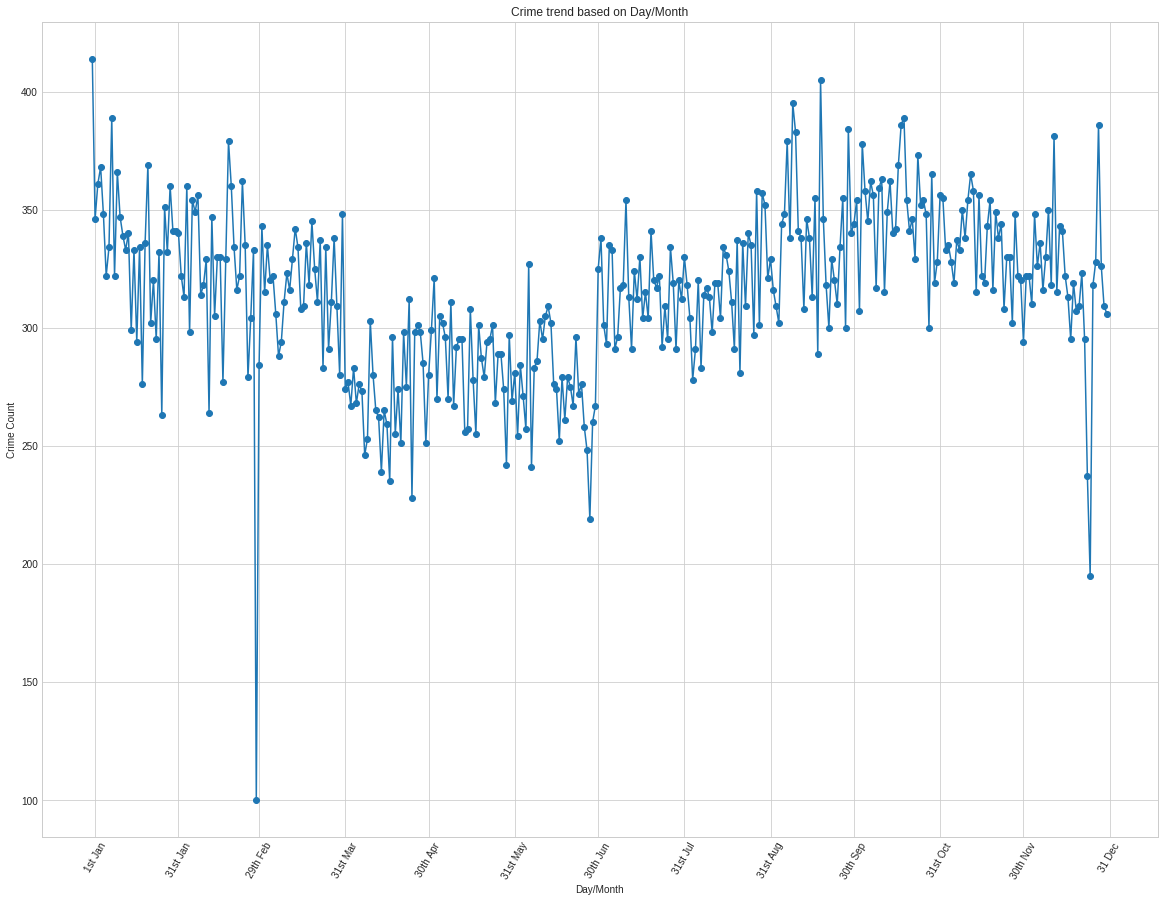

In [62]:
dayMonth_plot(date_list , offence_list, dates, date_index)